# ANN hyperparameter evaluation

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline

import itertools
import logging
import multiprocessing
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader, spectral_library
from ann_solo.config import config

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

# initialize logging
logging.basicConfig(format='%(asctime)s [%(levelname)s/%(processName)s] '
                           '%(module)s.%(funcName)s : %(message)s',
                    level=logging.INFO)

In [4]:
config_filename = '../../bin/ann-solo/iprg2012.ini'
splib_filename = '../../data/interim/iprg2012/human_yeast_targetdecoy.splib'
mgf_filename = '../../data/external/iprg2012/iPRG2012.mgf'
hp_dir = '../../data/processed/iprg2012/ann_hyperparameters'
build_dir = '../../data/processed/iprg2012/build_ann'

We consider the following hyperparameters for approximate nearest neighbor (ANN) searching:

- The number of lists in the ANN index (`num_list`).
- The number of lists in the ANN index to inspect during the search (`num_probe`).

Both of these hyperparameters provide a trade-off between speed and accuracy, either at build time or at run time.

For more information about the hyperparameters, please see the [Faiss](https://github.com/facebookresearch/faiss) library.

For each combination of hyperparameters the trade-off between search speed (total time required) and accuracy (number of PSMs at 1% FDR) is evaluated.
The number of identifications for a closed search (precursor mass = 20 ppm) and a traditional, brute-force, open modification search are indicated as a reference.

Search settings:

- Query file: spectra generated for the [iPRG 2012 study](http://www.mcponline.org/cgi/doi/10.1074/mcp.M113.032813).
- Precursor mass tolerance: 300 Da
- Fragment mass tolerance: 0.02 Da

In [5]:
def _do_search(settings):
    config.parse(settings)

    spec_lib = spectral_library.SpectralLibrary(
        config.spectral_library_filename)
    identifications = spec_lib.search(config.query_filename)
    writer.write_mztab(identifications, config.out_filename,
                       spec_lib._library_reader)
    spec_lib.shutdown()

# Go through all ANN hyperparameter combinations.
num_list_options = [64, 256, 1024, 4096, 16384]
num_probe_options = [1, 8, 32, 64, 128, 256, 512, 1024]
for num_list, num_probe in itertools.product(num_list_options,
                                             num_probe_options):
    if num_list > num_probe:
        out_filename = os.path.join(
            hp_dir, f'num_list_{num_list}-num_probe_{num_probe}.mztab')
        if not os.path.isfile(out_filename):
            settings = [f'--config {config_filename}',
                        '--precursor_tolerance_mass_open 300',
                        '--precursor_tolerance_mode_open Da',
                        '--mode ann',
                        f'--num_list {num_list}',
                        f'--num_probe {num_probe}',
                        splib_filename, mgf_filename, out_filename]

            proc = multiprocessing.Process(target=_do_search,
                                           args=(' '.join(settings),))
            proc.start()
            proc.join()

In [6]:
def extract_time_from_log(filename):
    with open(filename, 'r') as f_in:
        for line in f_in:
            if line.startswith('real'):
                # Wall clock time.
                realtime = line.split()[1]
                minutes = int(realtime[:realtime.find('m')])
                seconds = float(realtime[realtime.find('m') + 1:
                                         realtime.rfind('s')])
                realtime = minutes * 60 + seconds
                
                return realtime

In [7]:
pattern_hyperparameters_ssms = re.compile(
    '^num_list_(\d+)-num_probe_(\d+)(-no_gpu)?.mztab$')
pattern_hyperparameters_log = re.compile(
    '^num_list_(\d+)-num_probe_(\d+)(-no_gpu)?.log$')

ssms = []
runtimes = []
for filename in tqdm.tqdm(os.listdir(hp_dir), 'Files processed',
                          unit='files'):
    match_ssms = pattern_hyperparameters_ssms.match(filename)
    match_log = pattern_hyperparameters_log.match(filename)
    if match_ssms is not None:
        ssms.append((
            int(match_ssms.group(1)), int(match_ssms.group(2)),
            len(reader.read_mztab_ssms(os.path.join(hp_dir, filename))),
            match_ssms.group(3) is None))
    if match_log is not None:
        runtimes.append((
            int(match_log.group(1)), int(match_log.group(2)),
            extract_time_from_log(os.path.join(hp_dir, filename)),
            match_log.group(3) is None))

ssms_df = pd.DataFrame.from_records(
    ssms, columns=['num_list', 'num_probe', 'ssms', 'gpu'])
time_df = pd.DataFrame.from_records(
    runtimes, columns=['num_list', 'num_probe', 'time', 'gpu'])
hyperparameters = pd.merge(ssms_df, time_df,
                           on=['num_list', 'num_probe', 'gpu'])
hyperparameters['mode'] = 'ANN-SoLo'
hyperparameters['precursor_tol_mass'] = 300
hyperparameters['precursor_tol_mode'] = 'Da'

hyperparameters = hyperparameters.append(
    {'mode': 'Brute-force', 'precursor_tol_mass': 20,
     'precursor_tol_mode': 'ppm', 'num_list': -1, 'num_probe': -1,
     'ssms': len(reader.read_mztab_ssms(
         os.path.join(hp_dir, '..', 'brute_force', 'bf_std.mztab'))),
     'time': extract_time_from_log(
         os.path.join(hp_dir, '..', 'brute_force', 'bf_std.log')),
     'gpu': False
    }, ignore_index=True)

hyperparameters = hyperparameters.append(
    {'mode': 'Brute-force', 'precursor_tol_mass': 300,
     'precursor_tol_mode': 'Da', 'num_list': -1, 'num_probe': -1,
     'ssms': len(reader.read_mztab_ssms(
         os.path.join(hp_dir, '..', 'brute_force', 'bf_oms_shifted.mztab'))),
     'time': extract_time_from_log(
         os.path.join(hp_dir, '..', 'brute_force', 'bf_oms_shifted.log')),
     'gpu': False
    }, ignore_index=True)

hyperparameters = (hyperparameters[
    ['mode', 'precursor_tol_mass', 'precursor_tol_mode', 'num_list',
     'num_probe', 'ssms', 'time', 'gpu']]
    .sort_values(['precursor_tol_mass', 'num_list', 'num_probe', 'gpu'])
    .reset_index(drop=True))

In [8]:
hyperparameters['time'] = hyperparameters['time'] / 60

In [9]:
def get_pareto_frontier(arr):
    # Sort by the first column.
    arr_sorted = arr[arr[:, 0].argsort()]
    # Iteratively add points to the pareto frontier.
    pareto_idx = [0]
    for i in range(1, arr_sorted.shape[0]):
        if (arr_sorted[i, 1] > arr_sorted[pareto_idx[-1], 1] and
                arr_sorted[i, 0] - arr_sorted[pareto_idx[-1], 0] > 0.1):
            pareto_idx.append(i)
    return arr_sorted[pareto_idx]

In [10]:
hp_cpu = hyperparameters[(hyperparameters['mode'] == 'ANN-SoLo') &
                         ~(hyperparameters['gpu'])]
hp_cpu_pareto = get_pareto_frontier(hp_cpu[['time', 'ssms']].values)

hp_gpu = hyperparameters[(hyperparameters['mode'] == 'ANN-SoLo') &
                         (hyperparameters['gpu'])]
hp_gpu_pareto = get_pareto_frontier(hp_gpu[['time', 'ssms']].values)

hp_bf = hyperparameters[hyperparameters['mode'] == 'Brute-force']

fdr = 0.01

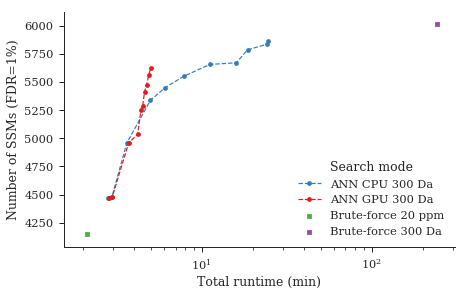

In [11]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# ANN-SoLo CPU performance.
ax.plot(hp_cpu_pareto[:, 0], hp_cpu_pareto[:, 1], '--o', color='C1',
        label='ANN CPU 300 Da')

# ANN-SoLo GPU performance.
ax.plot(hp_gpu_pareto[:, 0], hp_gpu_pareto[:, 1], '--o', color='C0',
        label='ANN GPU 300 Da')

# Brute-force closed & open performance.
for i, (_, row) in enumerate(hp_bf.iterrows(), 2):
    ax.scatter(row['time'], row['ssms'], marker='s', color=f'C{i}',
               label=f'{row["mode"]} {row["precursor_tol_mass"]} '\
                     f'{row["precursor_tol_mode"]}')

ax.set_xlabel('Total runtime (min)')
fdr = 0.01
ax.set_ylabel(f'Number of SSMs (FDR={fdr:.0%})')

ax.set_xscale('log')

ax.legend(loc='lower right', title='Search mode')

sns.despine()

# plt.savefig('ann_hyperparameters.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
num_spectra = len(list(reader.read_mgf(mgf_filename)))
num_id = (hyperparameters[(hyperparameters['mode'] == 'Brute-force') &
                          (hyperparameters['precursor_tol_mass'] == 300)]
          ['ssms'].iat[0])

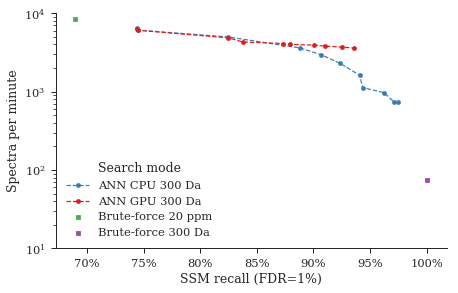

In [13]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# ANN-SoLo CPU performance.
ax.plot(hp_cpu_pareto[:, 1] / num_id, num_spectra / hp_cpu_pareto[:, 0],
        '--o', color='C1', label='ANN CPU 300 Da')

# ANN-SoLo GPU performance.
ax.plot(hp_gpu_pareto[:, 1] / num_id, num_spectra / hp_gpu_pareto[:, 0],
        '--o', color='C0', label='ANN GPU 300 Da')

# Brute-force closed & open timing.
for i, (_, row) in enumerate(hp_bf.iterrows(), 2):
    ax.scatter(row['ssms'] / num_id, num_spectra / row['time'],
               marker='s', color=f'C{i}',
               label=f'{row["mode"]} {row["precursor_tol_mass"]} '\
                     f'{row["precursor_tol_mode"]}')

ax.set_xlabel(f'SSM recall (FDR={fdr:.0%})')
ax.set_ylabel('Spectra per minute')

ax.set_yscale('log')
ax.set_ylim(10, 10000)
               
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

ax.legend(loc='lower left', title='Search mode')

sns.despine()

plt.savefig('ann_hyperparameters.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [14]:
# du -ch --block-size=1M human_yeast_targetdecoy_1* | grep total
build_sizes = {64: 3621, 256: 3624, 1024: 3638, 4096: 3677, 16384: 3777}

In [15]:
pattern_build_log = re.compile('^num_list_(\d+).log$')

build_runtimes = []
for filename in tqdm.tqdm(os.listdir(build_dir), 'Files processed',
                          unit='files'):
    match_build_log = pattern_build_log.match(filename)
    if match_build_log is not None:
        num_list = int(match_build_log.group(1))
        build_runtimes.append((
            num_list,
            extract_time_from_log(os.path.join(build_dir, filename)),
            build_sizes[num_list]))

build_df = pd.DataFrame.from_records(
    build_runtimes, columns=['num_list', 'build_time', 'size'])

In [16]:
build_df['build_time'] = build_df['build_time'] / 60
build_df['size'] = build_df['size'] / 1024
hyperparameters = hyperparameters.merge(build_df, how='outer', on='num_list')

In [17]:
table_latex = hyperparameters.copy()
# use pretty column names
table_latex['Search mode'] = (
    table_latex['mode'] + ' ' +
    table_latex['precursor_tol_mass'].map(str) + ' ' +
    table_latex['precursor_tol_mode'])
table_latex['num\_list'] = table_latex['num_list']
table_latex['Build time (\si{\minute})'] = table_latex['build_time'].map(
    '{:,.1f}'.format)
table_latex['Index size (\si{\giga\\byte})'] = table_latex['size'].map(
    '{:,.2f}'.format)
table_latex['{num\_probe}'] = table_latex['num_probe']
table_latex['GPU'] = table_latex['gpu'].map({True: '{\\boxedsymbols ✓}',
                                             False: '{\\boxedsymbols ✗}'})
table_latex['\#~SSMs'] = table_latex['ssms']
table_latex['Search time (\si{\minute})'] = table_latex['time'].map(
    '{:,.1f}'.format)
# Remove duplicated column values for pretty LaTeX output.
dup_columns = ['Search mode', 'num\_list', 'Build time (\si{\minute})',
               'Index size (\si{\giga\\byte})']
table_latex.loc[table_latex.duplicated(dup_columns), dup_columns] = ''
table_latex.loc[[False, True] * (len(table_latex) // 2), '{num\_probe}'] = ''
table_latex.loc[table_latex['Search mode'].str.contains('Brute-force'),
                ['num\_list', '{num\_probe}', 'Build time (\si{\minute})',
                 'Index size (\si{\giga\\byte})', 'GPU']] = ''
table_latex = table_latex.drop([
    'mode', 'precursor_tol_mass', 'precursor_tol_mode', 'num_list',
    'num_probe', 'ssms', 'time', 'build_time', 'size', 'gpu'], axis=1)
table_latex.to_latex(
    buf='tab-ann_hyperparameters.tex',
    index=False,
    column_format='@{\extracolsep{\\fill}}lrR{1cm}R{1cm}rrrR{1cm}',
    longtable=True, escape=False)

In [18]:
logging.shutdown()